## Predicting Stroke Risk Based on Lifestyle Habits - Logistic Regression Model

#### Import libraries

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

#### Read data

In [172]:
stroke_data = pd.read_csv("/content/I05-0006 stroke_risk.csv")
stroke_data.head()

,age,bmi,sleep_hours,smoking_status,exercise_frequency,stroke_risk
0,44,29.4,6.0,Former,High,No
1,76,29.3,10.1,Never,Low,No
2,43,23.6,3.4,Never,Low,Yes
3,59,33.5,5.7,Current,Moderate,No
4,77,26.0,6.1,Never,Low,No


#### Exploratory Data Analysis

In [173]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 500 non-null    int64  
 1   bmi                 500 non-null    float64
 2   sleep_hours         500 non-null    float64
 3   smoking_status      500 non-null    object 
 4   exercise_frequency  500 non-null    object 
 5   stroke_risk         500 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 23.6+ KB


In [174]:
stroke_data.describe()

,age,bmi,sleep_hours
count,500.000000,500.000000,500.000000
mean,55.426000,27.043600,7.039800
std,14.665151,4.918378,1.508797
min,30.000000,12.900000,2.700000
25%,42.000000,23.600000,6.000000
50%,57.000000,26.800000,7.000000
75%,68.000000,30.225000,8.100000
max,79.000000,43.900000,11.900000


In [175]:
stroke_data.isnull().sum()

,0
age,0
bmi,0
sleep_hours,0
smoking_status,0
exercise_frequency,0
stroke_risk,0


### Data Preprocessing

##### Outlier Detection and Winsorization

In [176]:
def detect_outliers_iqr(df, column):
  """
  Detects outliers in a column
  df: dataframe
  column: column name
  returns: lower and upper bounds of the column (useful for winsorization)
  """
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
  print(f"\nOutliers in {column}:")
  print(outliers[[column]])

  return lower_bound, upper_bound

In [177]:
# Previous visualization revealed outliers in these two classes, inspect them
bmi_lower, bmi_upper = detect_outliers_iqr(stroke_data, "bmi")
sleep_lower, sleep_upper = detect_outliers_iqr(stroke_data, "sleep_hours")


Outliers in bmi:
      bmi
161  43.9
238  40.2
352  12.9

Outliers in sleep_hours:
     sleep_hours
66           2.8
294         11.9
349          2.7
353          2.7


In [178]:
def cap_outliers(df, column, lower_bound, upper_bound):
  """
  Cap outliers in a column
  df: dataframe
  column: column name
  lower_bound: lower bound of the column
  upper_bound: upper bound of the column
  returns: dataframe with outliers capped
  """
  df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
  return df

In [179]:
stroke_data = cap_outliers(stroke_data, "bmi", bmi_lower, bmi_upper)
stroke_data = cap_outliers(stroke_data, "sleep_hours", sleep_lower, sleep_upper)

### Feature Engineering

In [180]:
# Bin ages into classes for clearer visualization of strok risk trend across age groups
bins = [30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
labels = ["30–34", "35-39", "40–44", "45-49", "50–54", "55-59", "60–64", "65-69", "70–74", "75-79"]
stroke_data["age_group"] = pd.cut(stroke_data["age"], bins=bins, labels=labels, right=False)
stroke_data.head()

,age,bmi,sleep_hours,smoking_status,exercise_frequency,stroke_risk,age_group
0,44,29.4,6.0,Former,High,No,40–44
1,76,29.3,10.1,Never,Low,No,75-79
2,43,23.6,3.4,Never,Low,Yes,40–44
3,59,33.5,5.7,Current,Moderate,No,55-59
4,77,26.0,6.1,Never,Low,No,75-79


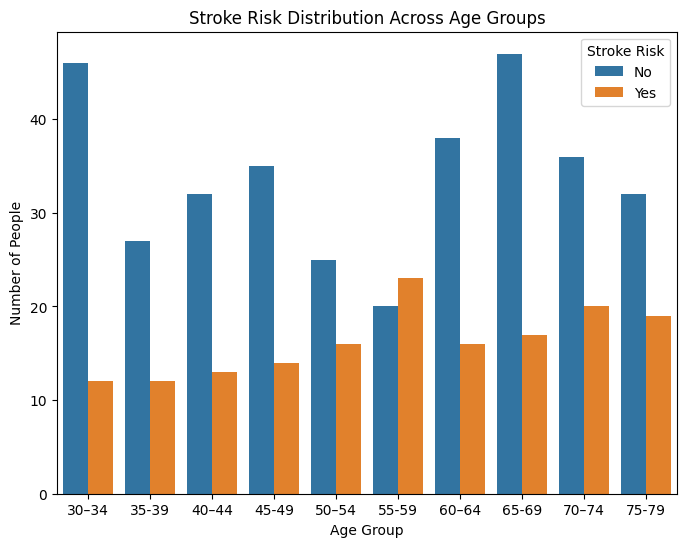

In [181]:
# Plot of stroke risk distribution across age groups to visualize possible trends
age_stroke_counts = stroke_data.groupby(["age_group", "stroke_risk"], observed=True).size().reset_index(name="count")
plt.figure(figsize=(8,6))
sns.barplot(data=age_stroke_counts, x="age_group", y="count", hue="stroke_risk")

plt.title("Stroke Risk Distribution Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Number of People")
plt.legend(title="Stroke Risk")
plt.show()

In [182]:
age_stroke_pivot = stroke_data.pivot_table(index="age_group", columns="stroke_risk",values="exercise_frequency",
                                          aggfunc='count',fill_value=0, observed=True)
age_stroke_pivot

stroke_risk,No,Yes
age_group,,
30–34,46,12
35-39,27,12
40–44,32,13
45-49,35,14
50–54,25,16
55-59,20,23
60–64,38,16
65-69,47,17
70–74,36,20


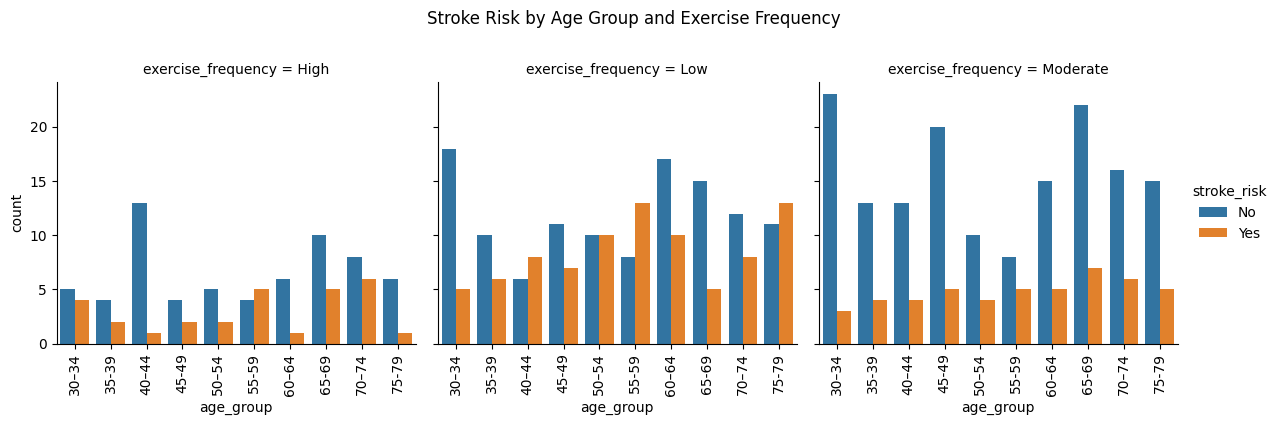

In [183]:
# Visualization showing the relationship between exercise frequency, age group, and stroke risk (useful for making decisions about feature engineering)
g = sns.catplot(data=stroke_data, x="age_group", hue="stroke_risk", col="exercise_frequency",
            kind="count", height=4,aspect=1)
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=90)
plt.subplots_adjust(top=0.8)
plt.suptitle("Stroke Risk by Age Group and Exercise Frequency")
plt.show()

In [184]:
def get_unique_cat(data, col):
  """
  Get unique values in a column
  data: dataframe
  col: column name
  returns: unique values in the column
  """
  return data[col].unique()

In [185]:
# Print unique values in categorical columns
categorical_cols = ["smoking_status", "exercise_frequency", "stroke_risk"]
for i in categorical_cols:
  print(f"Unique values in {i}: {get_unique_cat(stroke_data, i)}")

Unique values in smoking_status: ['Former' 'Never' 'Current']
Unique values in exercise_frequency: ['High' 'Low' 'Moderate']
Unique values in stroke_risk: ['No' 'Yes']


In [186]:
# Ordinal encoding for categorical columns
cat_cols = ["exercise_frequency", "stroke_risk"]
exercise_frequency_map = {"High":0, "Low":2, "Moderate":1}
stroke_risk_map = {"No":0, "Yes":1}
maps = [exercise_frequency_map, stroke_risk_map]

In [187]:
def ordinal_encoding(data, columns, maps):
  """
  Ordinal encoding for categorical columns
  data: dataframe
  columns: list of column names
  maps: list of maps for each column
  returns: dataframe with ordinal encoded columns
  """
  data = data.copy()
  for col, mapping in zip(columns, maps):
    data[col] = data[col].map(mapping)
  return data

In [188]:
# Confirm ordinal encoding
stroke_df = ordinal_encoding(stroke_data, cat_cols, maps)
for i in cat_cols:
  print(f"Unique values in {i}: {get_unique_cat(stroke_df, i)}")

Unique values in exercise_frequency: [0 2 1]
Unique values in stroke_risk: [0 1]


In [189]:
# One hot encoding for the smoking status column
stroke_df = pd.get_dummies(stroke_df, columns=["smoking_status"], drop_first=True, dtype=int)

In [190]:
# Adding new variables to account for feature relationships and importance
# 1 if age is less than 50, 2 if it is greater
stroke_df["age_above_50"] = (stroke_df["age"] > 50).astype(int) + 1
# product of exercise frequency and age
stroke_df["exercise_x_age"] = stroke_df["exercise_frequency"] * stroke_df["age"]
# product of exercise frequency and bmi
stroke_df["exercise_x_bmi"] = stroke_df["exercise_frequency"] * stroke_df["bmi"]
# variable to account for the relationship between bmi, exercise frequency and age class (product)
stroke_df["exercise_bmi_50"] = stroke_df["exercise_frequency"] * stroke_df["bmi"] * stroke_df["age_above_50"]
# product of sleep hours and exercise frequency
stroke_df["sleep_hours"] = stroke_df["sleep_hours"] * stroke_df["exercise_frequency"]
# Square the age variable to capture non-linearities
stroke_df["age_squared"] = stroke_df["age"] ** 2

In [191]:
def classify_bmi(bmi):
  """
  Classify bmi based on WHO metrics
  bmi: bmi value
  returns: bmi category
  """
  if bmi < 18.5:
      return 1
  elif 18.5 <= bmi < 25:
      return 2
  elif 25 <= bmi < 30:
      return 3
  elif 30 <= bmi < 35:
      return 4
  elif 35 <= bmi < 40:
      return 5
  else:
      return 6

stroke_df["bmi_class"] = stroke_df["bmi"].apply(classify_bmi)

In [192]:
# Inspect number of people in each bmi category
stroke_df["bmi_class"].value_counts()

,count
bmi_class,
3,187
2,158
4,111
5,25
1,16
6,3


In [193]:
# bmi values in class 5 are mostly for no-risk patients, confusing the model
# so drop values in that class
stroke_df = stroke_df[~stroke_df['bmi_class'].isin([5])].reset_index(drop=True)

In [194]:
# Add weight to BMI based on class
stroke_df["bmi"] = stroke_df["bmi"] * stroke_df["bmi_class"]
stroke_df["bmi_weighted"] = stroke_df["bmi"] * stroke_df["bmi_class"]

In [195]:
# Round sleep duration values to whole numbers
stroke_df["sleep_rounded"] = stroke_df["sleep_hours"].round()

In [196]:
# Inspect changes to dataframe
stroke_df.head()

,age,bmi,sleep_hours,exercise_frequency,stroke_risk,age_group,smoking_status_Former,smoking_status_Never,age_above_50,exercise_x_age,exercise_x_bmi,exercise_bmi_50,age_squared,bmi_class,bmi_weighted,sleep_rounded
0,44,88.2,0.0,0,0,40–44,1,0,1,0,0.0,0.0,1936,3,264.6,0.0
1,76,87.9,20.2,2,0,75-79,0,1,2,152,58.6,117.2,5776,3,263.7,20.0
2,43,47.2,6.8,2,1,40–44,0,1,1,86,47.2,47.2,1849,2,94.4,7.0
3,59,134.0,5.7,1,0,55-59,0,0,2,59,33.5,67.0,3481,4,536.0,6.0
4,77,78.0,12.2,2,0,75-79,0,1,2,154,52.0,104.0,5929,3,234.0,12.0


#### Checking for class imbalance in the target variable

In [197]:
class_counts = stroke_df['stroke_risk'].value_counts()
print("Number of samples per class:")
print(class_counts)

Number of samples per class:
stroke_risk
0    324
1    151
Name: count, dtype: int64


In [198]:
# Set Matplotlib parameters for figure size
plt.rcParams['figure.figsize'] = (8, 6)

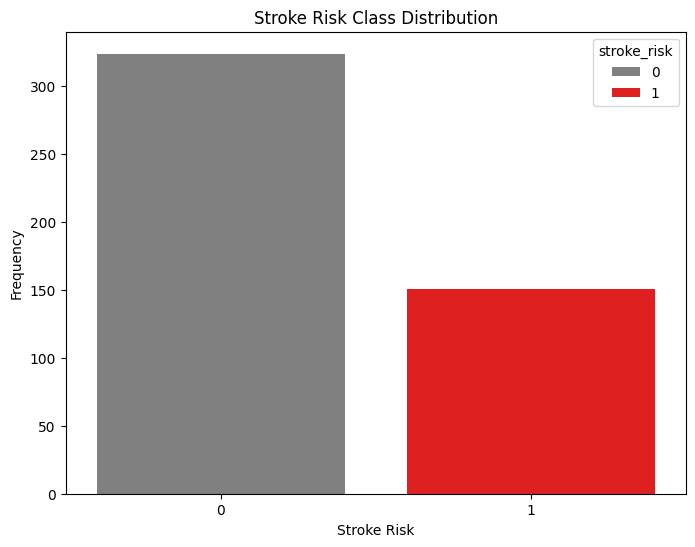

In [199]:
# Visualize target variable count
sns.countplot(x='stroke_risk', data=stroke_df, hue="stroke_risk", palette=["gray","red"])
plt.title("Stroke Risk Class Distribution")
plt.xlabel("Stroke Risk")
plt.ylabel("Frequency")
plt.show()

#### Check for collinearity

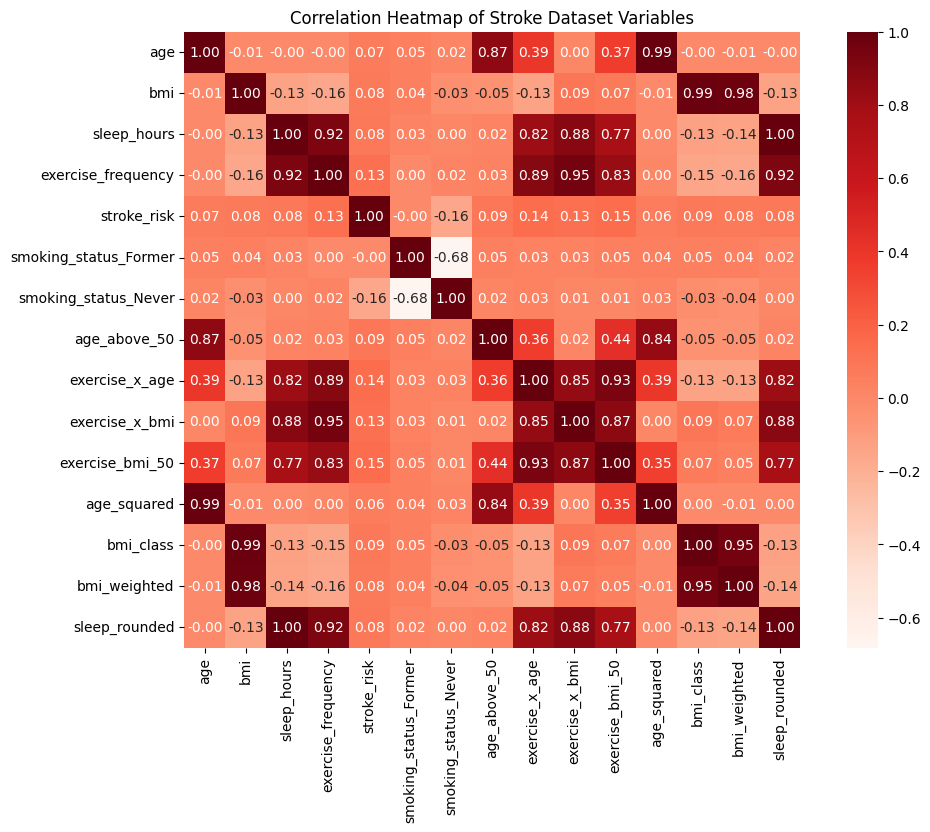

In [200]:
plt.figure(figsize=(12, 8))
corr = stroke_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Reds", square=True, cbar=True)
plt.title("Correlation Heatmap of Stroke Dataset Variables")
plt.show()

In [201]:
# Drop one column for columns with high correlations
X = stroke_df.drop(["stroke_risk", "age_group", "age", "age_above_50", "bmi", "sleep_hours"], axis=1)
y = stroke_df["stroke_risk"]

#### Deal with class imbalance

In [202]:
# Smote to upsample the minority class
smote = SMOTE(sampling_strategy={1: 200}, random_state=42)
X_smote, y_smote = smote.fit_resample(X,y)

In [203]:
# Random undersampling to downsample the majority class
undersample = RandomUnderSampler(random_state=7)
X_under, y_under = undersample.fit_resample(X_smote, y_smote)

In [204]:
class_counts = y_under.value_counts()
print("Number of samples per class:")
print(class_counts)

Number of samples per class:
stroke_risk
0    200
1    200
Name: count, dtype: int64


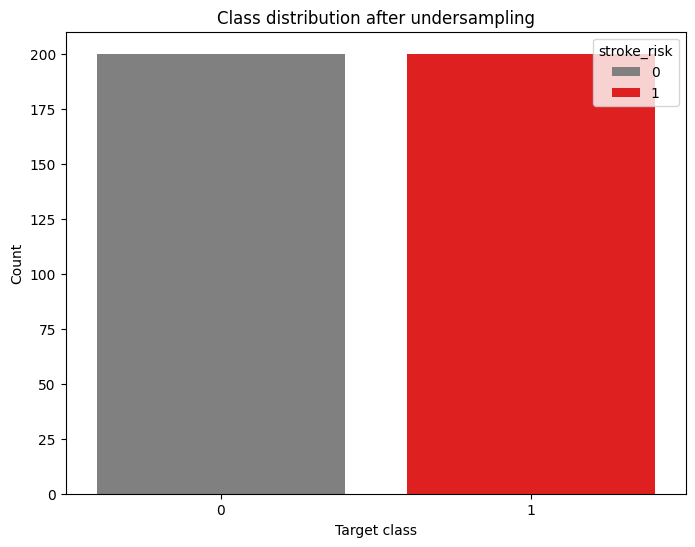

In [205]:
# Visualize target variable count after handling imbalance
palette = {0: "grey", 1: "red"}
sns.countplot(x=y_under, palette=["gray","red"], hue=y_under)
plt.title("Class distribution after undersampling")
plt.xlabel("Target class")
plt.ylabel("Count")
plt.show()


### Model Training and Evaluation

In [206]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

In [207]:
# Standardization for better results in logistic regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [208]:
# Fit logistic regressor
lr = LogisticRegression(C=1, penalty = "l1", solver = "saga", max_iter=5000)
lr.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=5000, penalty='l1', solver='saga')

In [209]:
# Make predictions and obtain metrics
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", confusion_mat)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 82.50%
Confusion Matrix:
 [[36  8]
 [ 6 30]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84        44
           1       0.79      0.83      0.81        36

    accuracy                           0.82        80
   macro avg       0.82      0.83      0.82        80
weighted avg       0.83      0.82      0.83        80



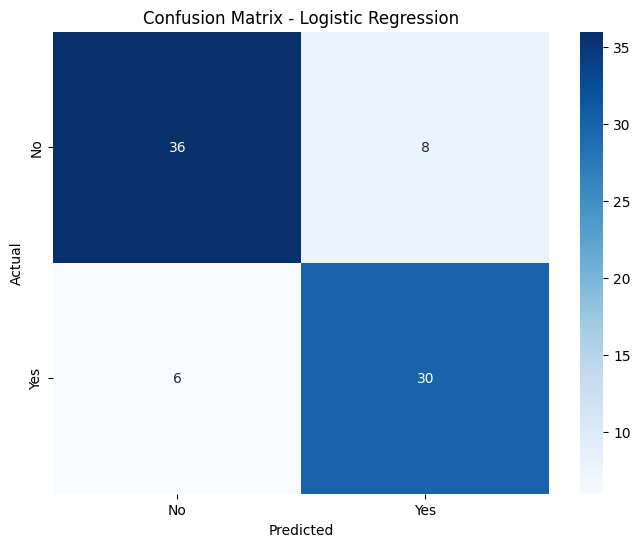

In [210]:
# Display confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

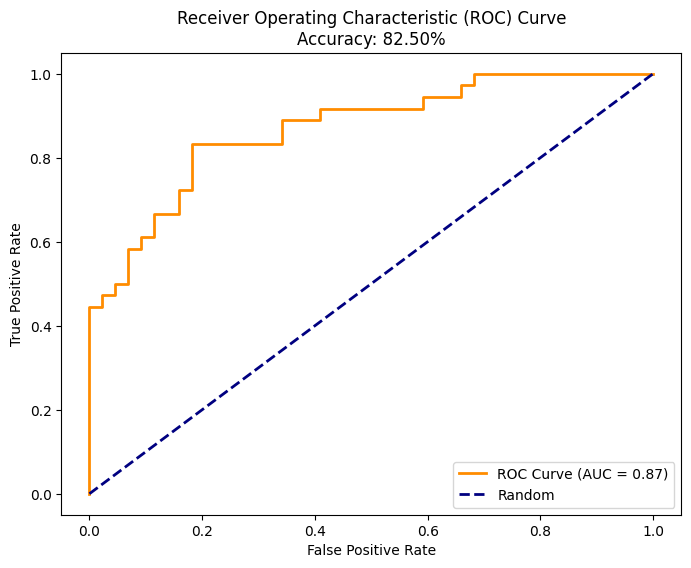

In [211]:
# Display ROC curve
y_prob = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()

#### Feature Importance

In [212]:
# Get model coefficient for each feature
feature_names = X_under.columns
coefficients = lr.coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)
print(coef_df)

                 Feature  Coefficient
3         exercise_x_age     0.359618
7              bmi_class     0.154350
6            age_squared     0.077923
0     exercise_frequency     0.000000
8           bmi_weighted     0.000000
4         exercise_x_bmi     0.000000
9          sleep_rounded     0.000000
5        exercise_bmi_50    -0.035643
1  smoking_status_Former    -0.430116
2   smoking_status_Never    -0.636938


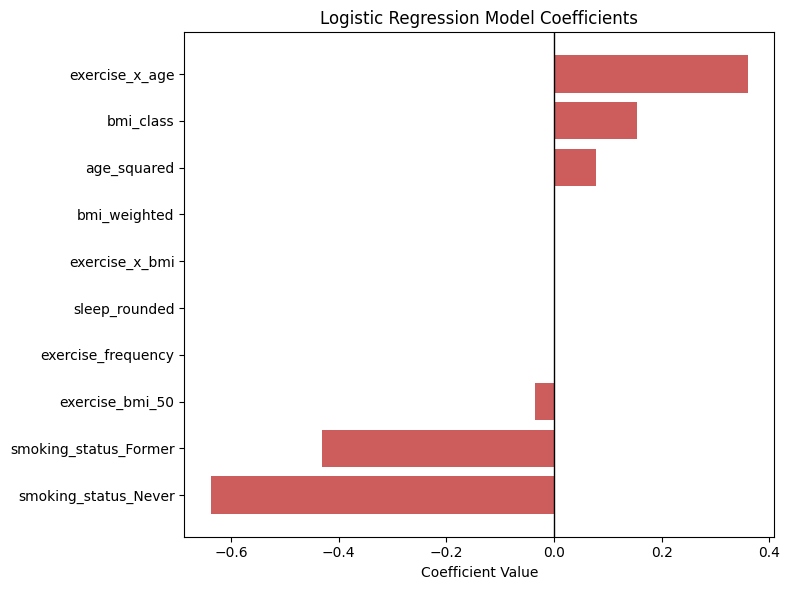

In [213]:
# Visualize model coefficients
coef_df_sorted = coef_df.sort_values(by="Coefficient", ascending=True)
plt.figure(figsize=(8,6))
plt.barh(coef_df_sorted["Feature"], coef_df_sorted["Coefficient"], color="indianred")
plt.axvline(x=0, color="black", linewidth=1)  # Reference line at 0
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Model Coefficients")
plt.tight_layout()
plt.show()